In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

from ipywidgets import widgets, interact, interactive


# Import AML APL peripheral blood cell dataset

The metadata table provides the ‘diagnosis’, ‘cohort’, ‘age at diagnosis’ and ‘gender’ for each of the participant IDs.  
Data from 106 patients are organised as folder ‘Patient_00’ to ‘Patient_105' then ‘Unsigned slides’ and ‘Signed slides’ .

In [2]:
#get path to data/main_dir
path_name = '../../data/PBC_dataset_APL_AML/'
path = Path(path_name)

In [3]:
training_glob = 'Signed slides'
validation_glob = 'Unsigned slides'

In [4]:
#create dataframe SIGNED
signed = pd.DataFrame()

signed['img_paths'] = [str(image) for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['id'] = [image.stem.split('_')[1] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['label'] = [image.stem.split('_')[0] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['cell_type'] = [image.parts[-2] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['patient'] = [image.parts[3] for image in path.rglob(f'{training_glob}/*/*.jpg')]

In [5]:
signed.shape

(15632, 5)

### remove corrupted files

In [6]:
%time
for file in signed['img_paths']:
    try:
        im = io.imread(file)
        
    except ValueError:
        print(file)
        signed = signed[~(signed['img_paths'] == file)] #remove truncated image
        

signed = signed.reset_index(drop=True)        

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 15 µs
../../data/PBC_dataset_APL_AML/Patient_30/Signed slides/Smudge cells/SMU_8371935.jpg
../../data/PBC_dataset_APL_AML/Patient_52/Signed slides/Lymphocyte/LY_8338724.jpg
../../data/PBC_dataset_APL_AML/Patient_24/Signed slides/Blast, no lineage spec/BL_7821735.jpg
../../data/PBC_dataset_APL_AML/Patient_58/Signed slides/Smudge cells/SMU_15364290.jpg
../../data/PBC_dataset_APL_AML/Patient_36/Signed slides/Blast, no lineage spec/BL_7744281.jpg
../../data/PBC_dataset_APL_AML/Patient_99/Signed slides/Smudge cells/SMU_17364544.jpg
../../data/PBC_dataset_APL_AML/Patient_37/Signed slides/Blast, no lineage spec/BL_6611696.jpg


### Add height, width and brightness to df

In [7]:
def add_columns(filename):
    
    im = io.imread(filename)
    temp = pd.DataFrame(index=[0])

    temp['height'] = im.shape[0] 
    temp['width'] = im.shape[1]
    temp['mean_brightness'] = np.mean(im)    
    
    im_gray = color.rgb2grey(im)
    temp['mean_luminance'] = np.mean(im_gray)
    
    return temp

In [8]:
addcol_bag = bag.from_sequence(signed.img_paths.to_list()).map(add_columns)
with diagnostics.ProgressBar():
    res = addcol_bag.compute()

[########################################] | 100% Completed | 26.2s


In [28]:
res_df = pd.concat(res).reset_index(drop=True)
df = signed.join(res_df)
df

,img_paths,id,label,cell_type,patient,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828414,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,204.708196,0.800781
1,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828371,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,194.427051,0.750937
2,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828375,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,199.196291,0.774121
3,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828478,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,198.018758,0.769578
4,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828494,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,183.606772,0.698534
...,...,...,...,...,...,...,...,...,...
15620,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616796,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,182.730624,0.693939
15621,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616831,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,191.774753,0.739277
15622,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616727,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,187.025214,0.717227
15623,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616815,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,198.971401,0.772237


In [11]:
# df.to_csv('../../data/PBC_dataset_AML_APL_raw.csv', index=False)
# df.to_pickle('../../data/PBC_dataset_AML_APL_raw.pkl')

# Sort labels

In [59]:
def plot_rand_class(label, df):
    plt.setp()
    temp_df =  df[df.label.isin(label)]

    display(temp_df.head())
    rand = np.random.choice(temp_df.index.to_numpy(), size = 35)
    
    fig, axes = plt.subplots(5, 7, figsize=(20, 10))

    for ax, idx in zip(axes.flatten(), rand):
        
        img = leuko.load_image(df.iloc[idx]['img_paths'])
        
        ax.imshow(img)
        lab = df.loc[idx]['label']
        ax.set_title(f'{idx} - {lab}', fontweight='bold')
    plt.tight_layout()
    return fig 

As in the healthy dataset:
- `BA`, basophils
- `MO`, Monocytes
- `LY`, Lymphocytes
- `EO`, eosinophils
- `ERB`, erythroblasts


- `MMY`,Metamyelocyte as IG
- `MY`,Myelocyte as IG
- `PMY`,Promyelocyte as IG


- `SNE`,Segmented neutrophils as NEU
- `BNE`, Band neutrophils as NEU

There is no label `PLT`

Let's merge the class as in the healthy dataset:

In [13]:
##### deprecated #####
# Fusion of neutrophil sub-groups 
# df["label"] = df["label"].replace(to_replace = ["SNE", "BNE","MY","MMY","PMY"], 
#                                   value = ["NEU", "NEU","IG","IG","IG"])

# other labels

- `BL`, Blast, no lineage spec, cancerous cells
- `SMU`,Smudge cells (fragile leukocytes)


Due to cancer

- `ERC`,Thrombocyte aggregation
- `GT`,Giant thrombocyte
<br /> <br />
- `PC`,Plasma cells
- `PLY`,Prolymphocyte
- `VLY`Lymphocyte, variant 
<br /> <br />
- `PMO`,Promonocyte/Promyelocyte

Other
- `ART`, Arifact  
- `UI`,Unidentified
- `USRWBC2`,Young Unidentified

## Misclassification

In [46]:
label_count = pd.DataFrame(df[['label', 'cell_type']].value_counts()).sort_values('label').rename(columns={0:'count'})
label_count.head()

count
label cell_type                    
ART   Monocyte                    1
      Arifact                    25
BA    Metamyelocyte               1
      Monocyte                    1
      Blast, no lineage spec      1

Some labels are misclassified as cell type or the other way around. Let's verify.

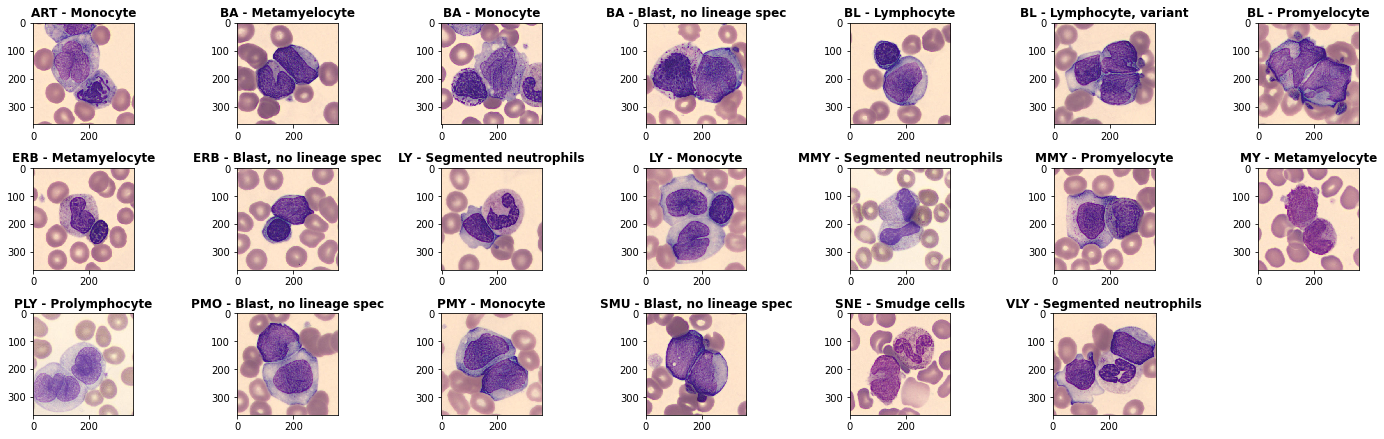

In [32]:
fig = plt.figure(figsize = (20,10))

for i, indices in enumerate(label_count[label_count['count']<2].index):
    label, celltype = indices
    plt.subplot(5, 7, i+1)
    io.imshow(df[(df['label'] == label) & (df['cell_type'] == celltype)]['img_paths'].item())
    plt.title(f'{label} - {celltype}', fontweight='bold')

In [33]:
label_count[label_count['count']<5].sum()/df.shape[0] *100

count    0.224
dtype: float64

### Conclusion
Most of the cells that are badly classified show 2 cells. We will exclude those values for now (0.2% of total dataset).

In [47]:
df2 = df.copy()
for indices in label_count[label_count['count']<5].index:
    label, celltype = indices
    df2 = df2.drop(df[(df['label'] == label) & (df2['cell_type'] == celltype)].index)


In [48]:
label_count = pd.DataFrame(df2[['label', 'cell_type']].value_counts()).sort_values('label').rename(columns={0:'count'})
label_count

,,count
label,cell_type,
ART,Arifact,25
BA,Basophil,53
BL,"Blast, no lineage spec",3297
BNE,Band neutrophils,171
EO,Eosinophils,108
ERB,Erythroblast,521
ERC,Thrombocyte aggregation,22
GT,Giant thrombocyte,66
LY,Lymphocyte,3428


## Others
UI, USRWBC2,ART
These cells are difficult to classify as such and the unidentified and young unidentified are obscure (0.35%). 
> Note: We could keep those cells for testing.



Some cells are classified as `unidentified` or `arifact` (Artifact) but look like blasts:  

Artifact 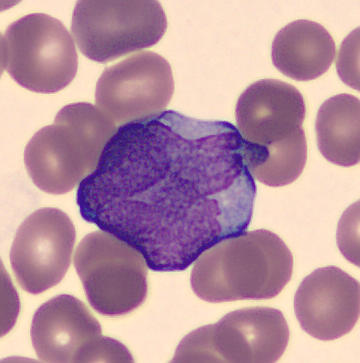 
Unidentified 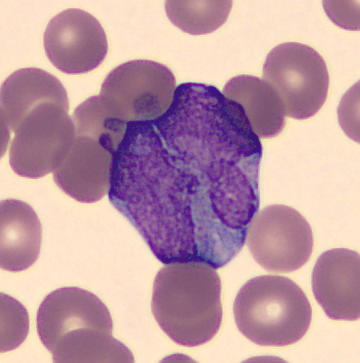 
Blast 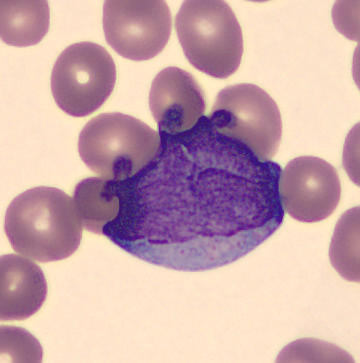

In [51]:
label_count = label_count.reset_index(drop=False)
label_count[label_count.label.isin(['ART', 'UI', 'USRWBC2'])]['count'].sum()/df.shape[0] *100

0.3584

In [52]:
label_count[label_count.label.isin(['ART', 'UI', 'USRWBC2'])][['cell_type', 'label']]

,cell_type,label
0,Arifact,ART
18,Unidentified,UI
19,Young Unidentified,USRWBC2


In [53]:
df3 = df2.copy()
for indices in label_count[label_count.label.isin(['ART', 'UI', 'USRWBC2'])].set_index(['label', 'cell_type']).index:
    label, celltype = indices
    df3 = df3.drop(df[(df['label'] == label) & (df3['cell_type'] == celltype)].index)


In [65]:
label_count = pd.DataFrame(df3[['label', 'cell_type']].value_counts()).sort_values('label').rename(columns={0:'count'})
label_count

,,count
label,cell_type,
BA,Basophil,53
BL,"Blast, no lineage spec",3297
BNE,Band neutrophils,171
EO,Eosinophils,108
ERB,Erythroblast,521
ERC,Thrombocyte aggregation,22
GT,Giant thrombocyte,66
LY,Lymphocyte,3428
MMY,Metamyelocyte,75


,img_paths,id,label,cell_type,patient,height,width,mean_brightness,mean_luminance
117,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828413,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,206.346189,0.806354
118,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828388,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,193.042411,0.741203
119,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828466,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,193.315345,0.743841
120,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828432,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,198.470625,0.769192
121,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828442,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,193.990720,0.745781


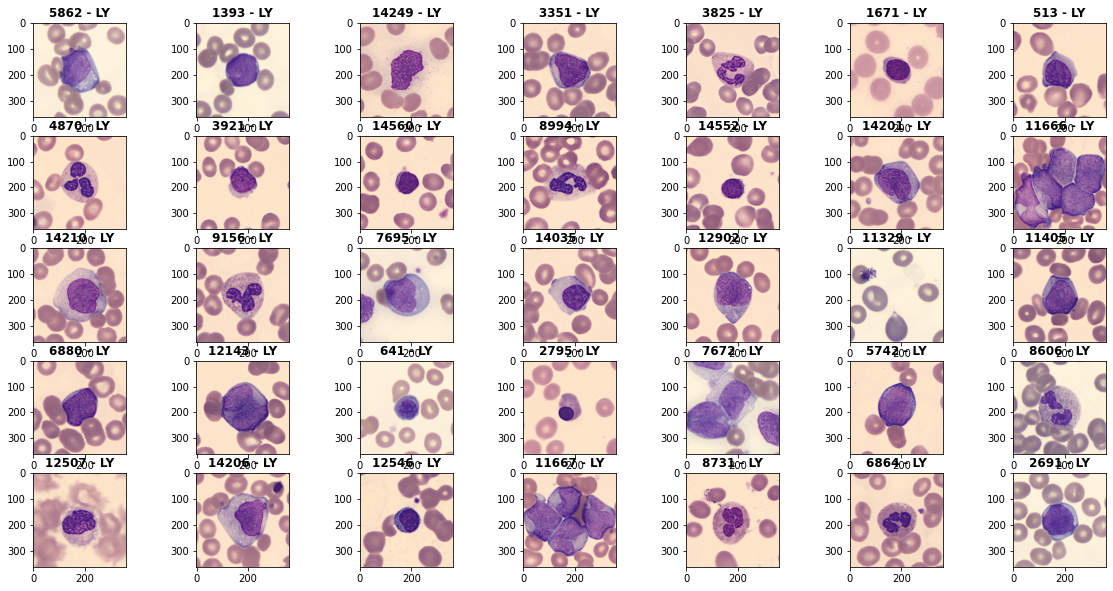

In [75]:
plot_rand_class(['LY'], df3);

<div class="alert alert-block alert-danger"><b>Problem:</b> Lots of misclassified cells - stop cleaning for now.</div>

In [15]:
@interact(label = df.label.unique(), celltype= df.cell_type.unique())
def show_im(label, celltype):
    temp_df = df[(signed.label==label) & (df.cell_type == celltype)]
    img = leuko.load_image(np.random.choice(temp_df["img_paths"]))
    return io.imshow(img)

interactive(children=(Dropdown(description='label', options=('ERB', 'VLY', 'NEU', 'IG', 'MO', 'SMU', 'LY', 'BL…

## Lymphocytes

Cancer tends to trigger lymphocytosis and thus the appearance of divergent morphologic lymphocytes:  
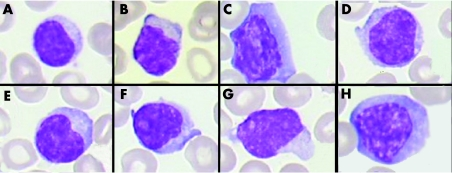

(A) lymphocyte with >90% accordance; (B) normal or atypical; (C) normal or plasma cell; (D) normal, atypical or prolymphocyte; (E) normal, atypical or plasma cell; (F) normal, atypical, prolymphocyte or plasma cell; (G) normal, atypical, prolymphocyte or blast; (H) normal, atypical, prolymphocyte, plasma cell or blast.

<font size="2"> <span style="color:grey"> Ref: The divergent morphological classification of variant lymphocytes in blood smears. W. van der Meer, J Clin Pathol. 2007  </span> </font>

,img_paths,id,label,cell_type,patient
32,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828445,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
33,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828407,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
34,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828464,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
35,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828483,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
36,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828496,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML


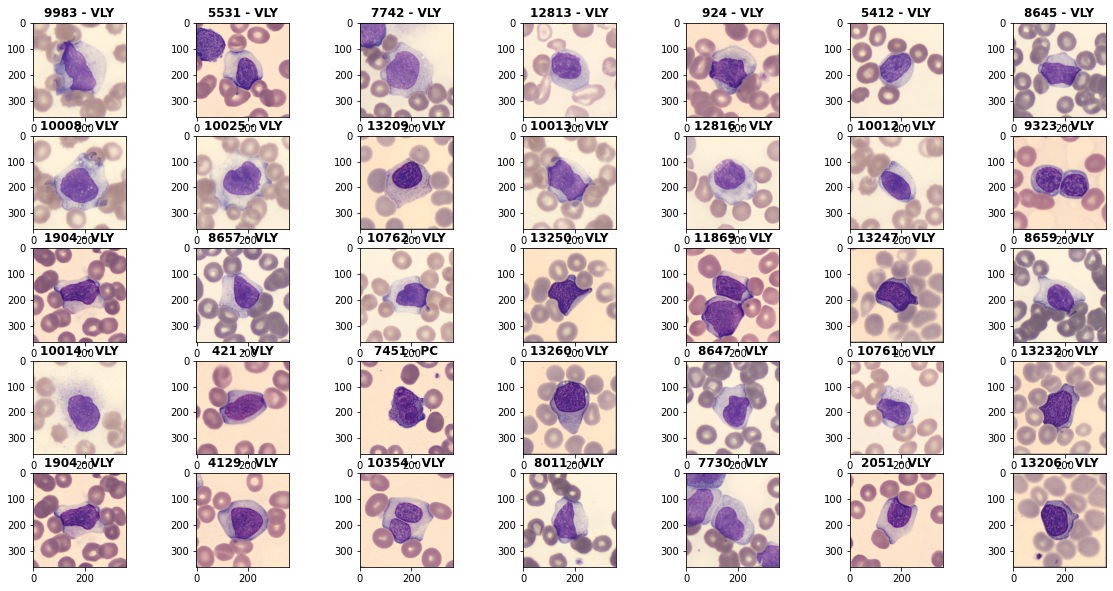

In [76]:
plot_rand_class(['PC', 'PLY', 'VLY'], signed);

# TO DO clean up cell